In [4]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Set CUDA device to 1 explicitly
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Make only GPU 1 visible
# Alternatively, you can use:
device = torch.device("cuda:0")  # This will now refer to the first visible device (CUDA 1)
print(f"Using device: {device}")

Using device: cuda:0


In [6]:
data = pd.read_csv('/media/ssd/test/standardized-datasets/netflow/nf_cic_ids2018_reduced.csv')

In [7]:
# Example if you wanted to keep only certain columns
columns_to_keep = ['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO',
                   'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label', 'Attack']
data = data[columns_to_keep]

In [8]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,193.111.198.10,14738,172.31.64.83,3389,6,0.000,1918.0,804.0,13,10,223,0.0,0,Benign
1,172.31.67.56,60565,172.31.0.2,53,17,0.000,69.0,197.0,1,1,0,0.0,0,Benign
2,172.31.67.104,49574,23.36.34.146,443,6,0.000,1848.0,55067.0,37,57,31,4294951.0,0,Benign
3,172.31.65.65,57848,172.31.0.2,53,17,0.000,66.0,163.0,1,1,0,0.0,0,Benign
4,172.31.64.115,58226,172.31.0.2,53,17,5.126,60.0,156.0,1,1,0,0.0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080705,172.31.65.45,60500,172.31.0.2,53,17,5.126,65.0,105.0,1,1,0,0.0,0,Benign
2080706,54.36.122.140,58370,172.31.64.70,8545,6,0.000,40.0,0.0,1,0,2,0.0,0,Benign
2080707,172.31.67.60,60255,172.31.0.2,53,17,0.000,68.0,167.0,1,1,0,0.0,0,Benign
2080708,209.90.32.82,55365,172.31.65.91,445,6,41.000,132.0,132.0,3,3,23,0.0,0,Benign


In [9]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [10]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)

In [11]:
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']

In [12]:
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

In [13]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,172.20.49.121:14738,172.31.64.83:3389,6,0.000,1918.0,804.0,13,10,223,0.0,0,Benign
1,172.30.68.243:60565,172.31.0.2:53,17,0.000,69.0,197.0,1,1,0,0.0,0,Benign
2,172.24.92.161:49574,23.36.34.146:443,6,0.000,1848.0,55067.0,37,57,31,4294951.0,0,Benign
3,172.17.195.6:57848,172.31.0.2:53,17,0.000,66.0,163.0,1,1,0,0.0,0,Benign
4,172.26.51.55:58226,172.31.0.2:53,17,5.126,60.0,156.0,1,1,0,0.0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...
2080705,172.24.120.248:60500,172.31.0.2:53,17,5.126,65.0,105.0,1,1,0,0.0,0,Benign
2080706,172.28.11.68:58370,172.31.64.70:8545,6,0.000,40.0,0.0,1,0,2,0.0,0,Benign
2080707,172.28.146.201:60255,172.31.0.2:53,17,0.000,68.0,167.0,1,1,0,0.0,0,Benign
2080708,172.16.119.229:55365,172.31.65.91:445,6,41.000,132.0,132.0,3,3,23,0.0,0,Benign


In [14]:
data.drop(columns=['Label'],inplace = True)

In [15]:
data.rename(columns={"Attack": "label"},inplace = True)

In [16]:
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])

In [17]:
label = data.label

In [18]:
data.drop(columns=['label'],inplace = True)

In [19]:
scaler = StandardScaler()

In [20]:
data =  pd.concat([data, label], axis=1)

In [21]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
0,172.20.49.121:14738,172.31.64.83:3389,6,0.000,1918.0,804.0,13,10,223,0.0,0
1,172.30.68.243:60565,172.31.0.2:53,17,0.000,69.0,197.0,1,1,0,0.0,0
2,172.24.92.161:49574,23.36.34.146:443,6,0.000,1848.0,55067.0,37,57,31,4294951.0,0
3,172.17.195.6:57848,172.31.0.2:53,17,0.000,66.0,163.0,1,1,0,0.0,0
4,172.26.51.55:58226,172.31.0.2:53,17,5.126,60.0,156.0,1,1,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2080705,172.24.120.248:60500,172.31.0.2:53,17,5.126,65.0,105.0,1,1,0,0.0,0
2080706,172.28.11.68:58370,172.31.64.70:8545,6,0.000,40.0,0.0,1,0,2,0.0,0
2080707,172.28.146.201:60255,172.31.0.2:53,17,0.000,68.0,167.0,1,1,0,0.0,0
2080708,172.16.119.229:55365,172.31.65.91:445,6,41.000,132.0,132.0,3,3,23,0.0,0


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.3, random_state=123,stratify= label)

In [23]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [24]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [25]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [26]:
X_train

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label,h
662098,172.20.212.210:64971,172.31.0.2:53,-1.350981,-0.500059,-0.031336,-0.013214,-0.028302,-0.029044,-0.565404,-0.537159,0,"[-0.5371585203105935, -0.029043717301218522, -..."
626381,172.20.14.113:65207,172.31.0.2:53,-1.350981,-0.500059,-0.031351,-0.013218,-0.028302,-0.029044,-0.565404,-0.537159,0,"[-0.5371585203105935, -0.029043717301218522, -..."
1611644,172.17.49.77:61821,172.31.64.12:3389,0.740421,-0.683276,-0.021280,-0.009217,-0.025276,-0.009540,-0.760873,-0.537159,0,"[-0.5371585203105935, -0.009540311696007508, -..."
1904377,172.25.147.6:50830,172.31.0.2:53,-1.350981,-0.500059,-0.030808,-0.012869,-0.027870,-0.025793,-0.565404,-0.537159,0,"[-0.5371585203105935, -0.02579314970035002, -0..."
1467018,172.28.204.165:34779,172.31.69.22:50389,0.740421,-0.500059,-0.031536,-0.013321,-0.028302,-0.029044,3.566358,-0.537159,12,"[-0.5371585203105935, -0.029043717301218522, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1524661,172.21.52.137:53892,50.23.200.73:443,0.740421,-0.500059,-0.023023,0.006816,-0.024411,0.006713,2.287135,-0.537159,0,"[-0.5371585203105935, 0.006712526308335004, -0..."
1599096,172.28.68.246:62761,172.31.69.28:80,0.740421,0.836642,-0.028094,-0.010842,-0.026573,-0.016041,0.341172,1.861826,4,"[1.8618260861120282, -0.01604144689774451, 0.8..."
1949518,172.18.209.158:55966,172.31.66.85:445,0.740421,-0.500059,-0.027165,-0.011454,-0.025708,-0.009540,0.087529,-0.537159,0,"[-0.5371585203105935, -0.009540311696007508, -..."
939365,172.18.172.241:58994,172.31.0.2:53,-1.350981,-0.460561,-0.031358,-0.013064,-0.028302,-0.029044,-0.565404,-0.537159,0,"[-0.5371585203105935, -0.029043717301218522, -..."


In [27]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [28]:
G = G.to_directed()


In [29]:
G = from_networkx(G,edge_attrs=['h','label'] )


In [30]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [31]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)


In [32]:
G.edata['train_mask'] 

tensor([True, True, True,  ..., True, True, True])

In [33]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [34]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [35]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [36]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [37]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 15)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [38]:
from sklearn.utils import class_weight
import numpy as np # Ensure numpy is imported

# Calculate unique classes and labels once
labels_array = G.edata['label'].cpu().numpy()
unique_classes = np.unique(labels_array)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=unique_classes, # Use keyword 'classes='
    y=labels_array          # Use keyword 'y='
)

# Optional: Convert to a dictionary usable by many frameworks
class_weights_dict = dict(zip(unique_classes, class_weights))
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 0.09264885629474419, 1: 1.9387389186167239, 2: 129.29400798934753, 3: 149.6144838212635, 4: 0.6416851704996035, 5: 131.3935047361299, 6: 2.2569801496908557, 7: 10.007193651448006, 8: 1.603074078354328, 9: 19.651851851851852, 10: 29.167858215680383, 11: 10.698523578669016, 12: 2.384221381918185, 13: 321.5225165562914, 14: 2.920909665192672}


In [39]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [40]:
G = G.to('cuda:0')
G.device

device(type='cuda', index=0)

In [41]:
G.ndata['h'].device


device(type='cuda', index=0)

In [42]:
G.edata['h'].device


device(type='cuda', index=0)

In [43]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

for epoch in range(1,8000):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


Training acc: 0.897104799747467
Training acc: 0.6369515061378479
Training acc: 0.5999414920806885
Training acc: 0.7833204865455627
Training acc: 0.634310245513916
Training acc: 0.6234990358352661
Training acc: 0.7000827789306641
Training acc: 0.6528005003929138
Training acc: 0.6410775184631348
Training acc: 0.5609283447265625
Training acc: 0.6359439492225647
Training acc: 0.8672478795051575
Training acc: 0.637125551700592
Training acc: 0.6054739356040955
Training acc: 0.6275275349617004
Training acc: 0.6081608533859253
Training acc: 0.6221433877944946
Training acc: 0.6910759210586548
Training acc: 0.6272563338279724
Training acc: 0.6297461986541748
Training acc: 0.5779204964637756
Training acc: 0.5472221970558167
Training acc: 0.5746166706085205
Training acc: 0.6355416178703308
Training acc: 0.5656242370605469
Training acc: 0.5927107930183411
Training acc: 0.8990381956100464
Training acc: 0.5716801881790161
Training acc: 0.6069644689559937
Training acc: 0.6333006024360657
Training acc:

In [44]:
X_test = encoder.transform(X_test)

In [45]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [46]:
X_test

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
1828944,172.24.130.106:443,172.31.69.30:50082,0.740421,-0.625317,-0.005825,-0.011443,-0.024843,-0.003039,0.087529,1.861831,0
361110,172.21.129.160:52151,18.219.211.138:8080,0.740421,-0.304888,-0.027730,-0.012647,-0.026573,-0.016041,0.341172,-0.537159,1
1653785,172.17.140.97:54819,172.31.0.2:53,-1.350981,-0.500059,-0.031365,-0.013037,-0.028302,-0.029044,-0.565404,-0.537159,0
767616,172.20.174.46:58498,172.31.69.25:80,0.740421,1.044102,-0.009575,0.000057,-0.017925,0.048970,2.287135,1.861691,8
16179,172.22.2.135:52524,172.31.0.2:53,-1.350981,-0.500059,-0.031351,-0.013218,-0.028302,-0.029044,-0.565404,-0.537159,0
...,...,...,...,...,...,...,...,...,...,...,...
89776,172.30.6.50:37450,172.31.64.83:3389,0.740421,-0.500059,-0.020038,-0.006279,-0.023546,-0.003039,-0.644160,-0.537159,0
654063,172.16.67.224:61317,172.31.69.28:80,0.740421,1.044102,-0.028008,-0.010842,-0.026573,-0.016041,0.341172,1.861830,4
1441617,172.20.195.69:54744,172.31.68.25:3389,0.740421,-0.500059,-0.021280,-0.009217,-0.025276,-0.009540,-0.760873,-0.537159,0
1448461,172.22.171.108:51030,108.161.189.121:443,0.740421,-0.500059,-0.021552,-0.000373,-0.020952,0.016464,0.341172,-0.537159,0


In [47]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [48]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [49]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [50]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [51]:
G_test = G_test.to('cuda:0')


In [52]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [53]:
print(str(elapsed) + ' seconds')


0.12739259004592896 seconds


In [54]:
test_pred = test_pred.argmax(1)


In [55]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [56]:
actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [57]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

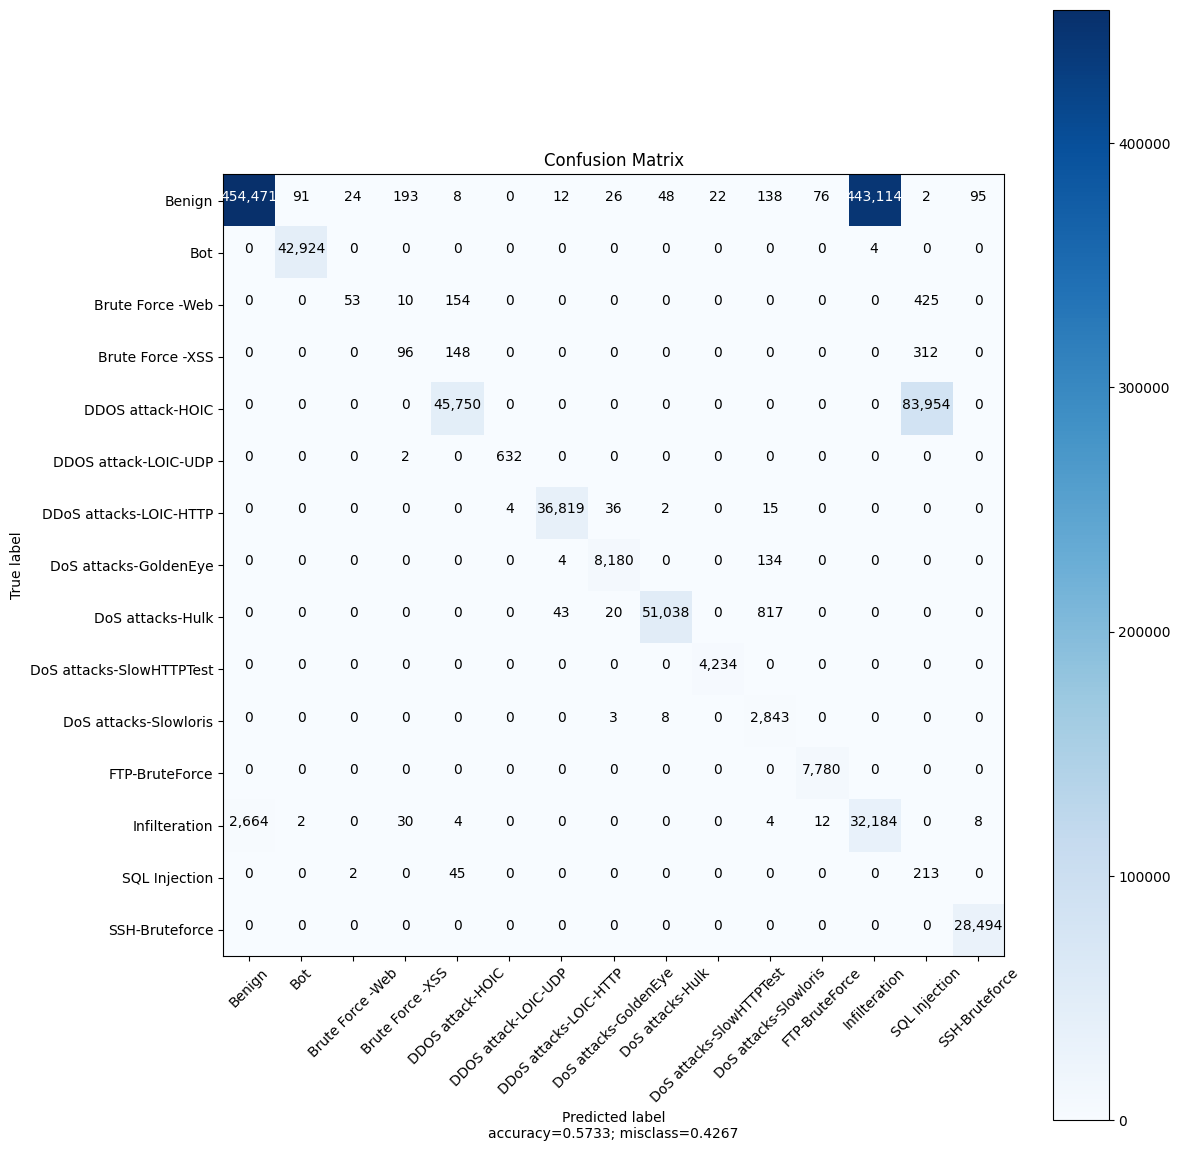

In [58]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")